Shape of X_train_0: (99990, 10)
Shape of Y_train_0: (99990, 10, 2)
Shape of X_train_1: (99990, 10)
Shape of Y_train_1: (99990, 10, 2)
Shape of X_train_2: (99990, 10)
Shape of Y_train_2: (99990, 10, 2)


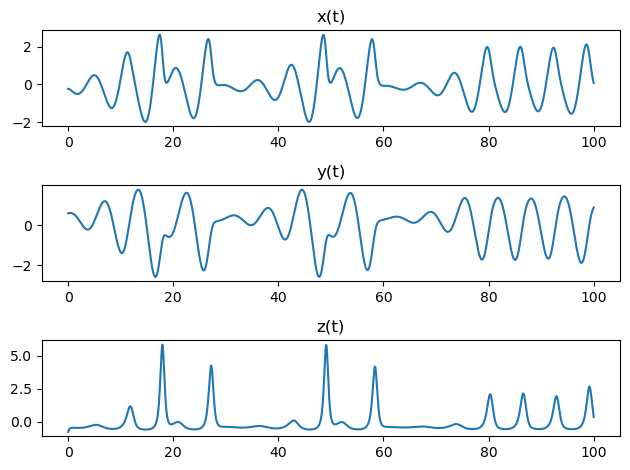

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Define the Rössler equations
def rossler(Y, a, b, c):
    x, y, z = Y
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return np.array([dxdt, dydt, dzdt])

# Parameters
a = 0.5
b = 2.0
c = 4.0

# Initial conditions
Y = np.array([0.1, 0, 0])

# Time step and total time
dt = 0.001
T = 100
n_steps = int(T/dt)

# Create an array to store the solution
solution = np.zeros((n_steps, 3))
solution[0] = Y

# Time grid for integration
t = np.linspace(0, T, n_steps)

# Euler's method
for i in range(1, n_steps):
    Y = Y + rossler(Y, a, b, c) * dt
    solution[i] = Y
solution = zscore(solution, axis=0)  # Normalize the solution

# Define function to create training data for reservoir computing
def create_rc_training_data_multi(solution, N):
    data = {}
    for i in range(3):  # For each coordinate (x, y, z)
        X, Y = [], []
        for j in range(len(solution) - N):
            X.append(solution[j:j+N, i])
            Y.append(np.delete(solution[j:j+N, :], i, axis=1))
        data[f"X_train_{i}"] = np.array(X)
        data[f"Y_train_{i}"] = np.array(Y)
    return data

# Create training data with sequence length N
N = 10
training_data = create_rc_training_data_multi(solution, N)

# Print shape of training data
for k, v in training_data.items():
    print(f"Shape of {k}:", v.shape)


# Plot the solution
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t, solution[:, 0])
plt.title('x(t)')
plt.subplot(3, 1, 2)
plt.plot(t, solution[:, 1])
plt.title('y(t)')
plt.subplot(3, 1, 3)
plt.plot(t, solution[:, 2])
plt.title('z(t)')
plt.tight_layout()
plt.show()


Root Mean Square Error: 1.234972876538402


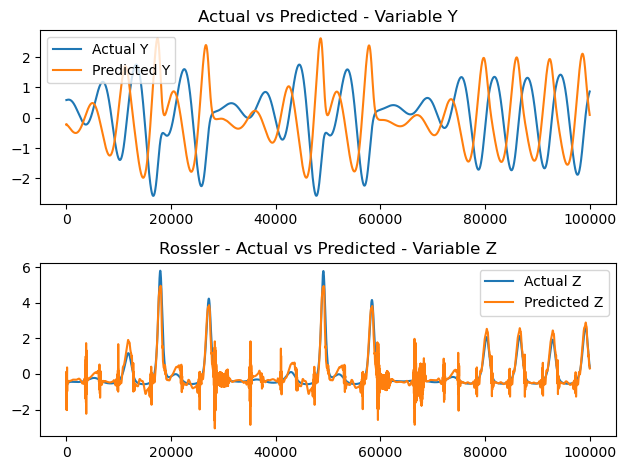

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

N = 200  # Reservoir size
M = 10  # Input size, based on your data
P = 2  # Output size
a = 0.3  # Leakage rate
dt = .001  # Time step, assuming discrete steps in your time series
D = 10  # Average degree of reservoir nodes
q = 1.2  # Spectral radius
r = 0.5  # Input layer scaling
n = 0.01  # Bias term

def predict(A, Win, Wout, input_seq):
    T, _ = input_seq.shape
    r = np.zeros(N)
    predicted_output = np.zeros((T, P))
    for t in range(T):
        u = input_seq[t, :]
        r = (1 - a) * r + a * tanh_vectorized(np.dot(A, r) + np.dot(Win, u) + n)
        predicted_output[t, :] = np.dot(Wout, r)
    return predicted_output

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))


# Reservoir Weight Matrix (A)
A = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if np.random.rand() < D / N:
            A[i, j] = np.random.uniform(-1, 1)

# Rescale A
eigenvalues = np.linalg.eigvals(A)
A *= q / np.max(np.abs(eigenvalues))

# Input Weight Matrix (Win)
Win = np.random.uniform(-r, r, (N, M))

# Training data
X_train_0 = training_data["X_train_0"]
Y_train_0 = training_data["Y_train_0"]

# Training data2
X_train_1 = training_data["X_train_1"]
Y_train_1 = training_data["Y_train_1"]

# Training data 3
X_train_2 = training_data["X_train_2"]
Y_train_2 = training_data["Y_train_2"]

T, _ = X_train_0.shape

# Initialize reservoir state and output weights
r = np.zeros(N)
Wout = np.random.rand(P, N)  # Randomly initialize output weights

def tanh_vectorized(x):
    return np.tanh(x)

r_collect = np.zeros((T, N))
Y_collect = np.zeros((T, P))

for t in range(T):
    u = X_train_0[t, :]
    r = (1 - a) * r + a * np.tanh(np.dot(A, r) + np.dot(Win, u) + n)
    r_collect[t, :] = r
    Y_collect[t, :] = Y_train_1[t, 0, :]  # Assuming you're using the first time step as label


# Assuming r_collect and Y_collect store the reservoir states and true labels over time for training
model = LinearRegression().fit(r_collect, Y_collect)
Wout = model.coef_

predicted_output = predict(A, Win, Wout, X_train_0)

predicted_output = zscore(predicted_output, axis=0)  # Normalize the predicted output

# Calculate RMSE
error = rmse(Y_train_0[:, 0, :], predicted_output)
print(f'Root Mean Square Error: {error}')

# Assuming both dimensions of labels
actual_dim1 = Y_train_0[:, 0, 0]
actual_dim2 = Y_train_0[:, 0, 1]
predicted_dim1 = predicted_output[:, 0]
predicted_dim2 = predicted_output[:, 1]

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(actual_dim1, label='Actual Y')
plt.plot(predicted_dim1, label='Predicted Y')
plt.legend()
plt.title('Actual vs Predicted - Variable Y')

plt.subplot(2, 1, 2)
plt.plot(actual_dim2, label='Actual Z')
plt.plot(predicted_dim2, label='Predicted Z')
plt.legend()
plt.title('Rossler - Actual vs Predicted - Variable Z')

plt.tight_layout()
plt.show()

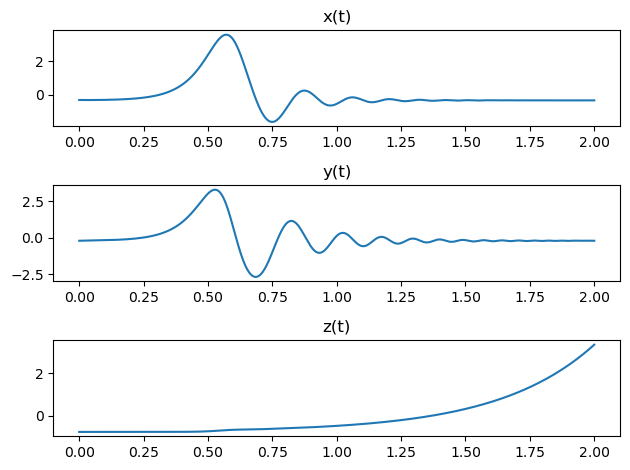

Shape of X_train_0: (1990, 10)
Shape of Y_train_0: (1990, 10, 2)
Shape of X_train_1: (1990, 10)
Shape of Y_train_1: (1990, 10, 2)
Shape of X_train_2: (1990, 10)
Shape of Y_train_2: (1990, 10, 2)


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the Lorenz equations
def lorenz(Y, t, a, b, c):
    x, y, z = Y
    dxdt = -a * x + a * y
    dydt = b * x - y - x * z
    dzdt = c * z + x * y
    return [dxdt, dydt, dzdt]

# Parameters
a = 10.0
b = 28.0
c = 8.0/3.0

# Initial conditions
Y = np.array([0.1, 0.0, 0.0])

# Time step and total time
dt = 0.001
T = 2
n_steps = int(T/dt)

# Time grid for integration
t = np.linspace(0, T, n_steps)

# Solve the differential equations using odeint
solution_lorenz = odeint(lorenz, Y, t, args=(a, b, c))
solution_lorenz = zscore(solution_lorenz, axis=0)  # Normalize the solution

# Plot the solution
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t, solution_lorenz[:, 0])
plt.title('x(t)')
plt.subplot(3, 1, 2)
plt.plot(t, solution_lorenz[:, 1])
plt.title('y(t)')
plt.subplot(3, 1, 3)
plt.plot(t, solution_lorenz[:, 2])
plt.title('z(t)')
plt.tight_layout()
plt.show()

# Define function to create training data for reservoir computing
def create_rc_training_data_multi_lorenz(solution, N):
    data = {}
    for i in range(3):  # For each coordinate (x, y, z)
        X, Y = [], []
        for j in range(len(solution) - N):
            X.append(solution[j:j+N, i])
            Y.append(np.delete(solution[j:j+N, :], i, axis=1))
        data[f"X_train_{i}"] = np.array(X)
        data[f"Y_train_{i}"] = np.array(Y)
    return data

# Create training data with sequence length N
N = 10
training_data_lorenz = create_rc_training_data_multi_lorenz(solution_lorenz, N)

# Print shape of training data
for k, v in training_data_lorenz.items():
    print(f"Shape of {k}:", v.shape)



Root Mean Square Error: 0.6296765462183154


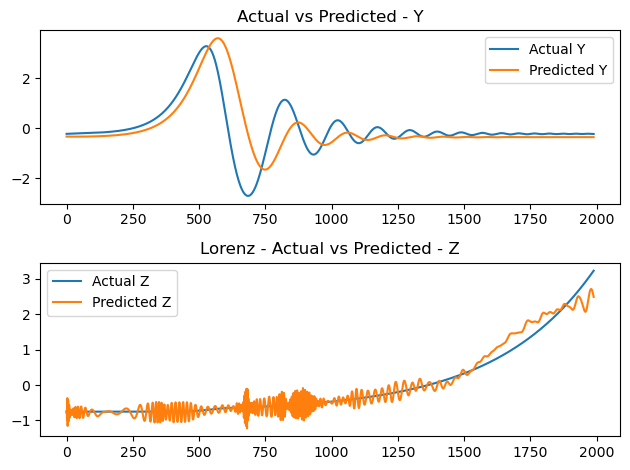

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

N = 200  # Reservoir size
M = 10  # Input size, based on your data
P = 2  # Output size
a = 0.3  # Leakage rate
dt = .001  # Time step, assuming discrete steps in your time series
D = 10  # Average degree of reservoir nodes
q = 1.2  # Spectral radius
r = 0.5  # Input layer scaling
n = 0.01  # Bias term

def predict(A, Win, Wout, input_seq):
    T, _ = input_seq.shape
    r = np.zeros(N)
    predicted_output = np.zeros((T, P))
    for t in range(T):
        u = input_seq[t, :]
        r = (1 - a) * r + a * tanh_vectorized(np.dot(A, r) + np.dot(Win, u) + n)
        predicted_output[t, :] = np.dot(Wout, r)
    return predicted_output

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))


# Reservoir Weight Matrix (A)
A = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if np.random.rand() < D / N:
            A[i, j] = np.random.uniform(-1, 1)

# Rescale A
eigenvalues = np.linalg.eigvals(A)
A *= q / np.max(np.abs(eigenvalues))

# Input Weight Matrix (Win)
Win = np.random.uniform(-r, r, (N, M))

# Training data
X_train_0 = training_data_lorenz["X_train_0"]
Y_train_0 = training_data_lorenz["Y_train_0"]

# Training data2
X_train_1 = training_data_lorenz["X_train_1"]
Y_train_1 = training_data_lorenz["Y_train_1"]

# Training data 3
X_train_2 = training_data_lorenz["X_train_2"]
Y_train_2 = training_data_lorenz["Y_train_2"]

T, _ = X_train_0.shape

# Initialize reservoir state and output weights
r = np.zeros(N)
Wout = np.random.rand(P, N)  # Randomly initialize output weights

def tanh_vectorized(x):
    return np.tanh(x)

r_collect = np.zeros((T, N))
Y_collect = np.zeros((T, P))

for t in range(T):
    u = X_train_0[t, :]
    r = (1 - a) * r + a * np.tanh(np.dot(A, r) + np.dot(Win, u) + n)
    r_collect[t, :] = r
    Y_collect[t, :] = Y_train_1[t, 0, :]  # Assuming you're using the first time step as label


# Assuming r_collect and Y_collect store the reservoir states and true labels over time for training
model = LinearRegression().fit(r_collect, Y_collect)
Wout = model.coef_

predicted_output = predict(A, Win, Wout, X_train_0)

predicted_output = zscore(predicted_output, axis=0)  # Normalize the predicted output

# Calculate RMSE
error = rmse(Y_train_0[:, 0, :], predicted_output)
print(f'Root Mean Square Error: {error}')

# Assuming both dimensions of labels
actual_dim1 = Y_train_0[:, 0, 0]
actual_dim2 = Y_train_0[:, 0, 1]
predicted_dim1 = predicted_output[:, 0]
predicted_dim2 = predicted_output[:, 1]

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(actual_dim1, label='Actual Y')
plt.plot(predicted_dim1, label='Predicted Y')
plt.legend()
plt.title('Lorenz - Actual vs Predicted - Y')

plt.subplot(2, 1, 2)
plt.plot(actual_dim2, label='Actual Z')
plt.plot(predicted_dim2, label='Predicted Z')
plt.legend()
plt.title('Lorenz - Actual vs Predicted - Z')

plt.tight_layout()
plt.show()